# 0.0 Theory


# 0.1 Create a class, provide methods

In [113]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
from math import comb

def _calculate_conditional_probability(self, prob_a: float, prob_b: float, prob_b_given_a: float):
    """
    Calculates the conditional probability
    Args:
        prob_a (float): Probability of event A
        prob_b (float): Probability of event B
        prob_b_given_a (float): Probability of event B given the event A
    """
    return prob_b_given_a*prob_a/prob_b # p(A|B)


class MultipleEvidence():
    def __init__(self, number_of_evidences: int, test_mode: bool = False):
        self.number_of_evidences = number_of_evidences
        # Use better data structures for clarity
        self.initial_event = {}
        self.conditional_evidences = {}

        if test_mode:
            print("Loading hardcoded data")
            self._load_test_data()
        else:
            self._define_evidences()

    def _get_valid_name(self, prompt: str) -> str:
        """
        Keeps asking the user for a name until a valid, non-empty, non-numeric string is provided
        """
        while True:
            name = input(prompt).strip()
            # Checking is it empty
            if not name:
                print("Error: The name cannot be empty.")
                continue
            # Checking the type of the 'name'
            try:
                float(name)
                print("Error: The name cannot be a number. Please use a text-based name")
            except ValueError:
                # Success! float() failed, so it's not a number
                return name # Return the valid name and exit the function.

    def _get_valid_probability(self, prompt: str) -> float:
        """
        Keeps asking the user for a probability until a valid float between 0.0 and 1.0 is provided
        """
        while True:
            user_input = input(prompt)
            try:
                prob = float(user_input)
                if 0.0 <= prob <= 1.0:
                    return prob #Return the valid float and exit the function.
                else:
                    print("Error: The probability must be a number between 0.0 and 1.0")
            except ValueError:
                print("Error: Invalid input. Please enter a number ")

    def _get_valid_probability_list(self, prompt: str, count: int) -> list[float]:
        """Keeps asking for a comma-separated list of N probabilities"""
        while True:
            csv_input = input(prompt)
            parts = [p.strip() for p in csv_input.split(',')]

            if len(parts) != count:
                print(f"Error: Please provide exactly {count} probabilities separated by a comma.")
                continue

            try:
                probs = [float(p) for p in parts]
                if all(0.0 <= p <= 1.0 for p in probs):
                    return probs
                else:
                    print("Error: All probabilities must be between 0.0 and 1.0.")
            except ValueError:
                print("Error: One or more items were not valid numbers. Please try again")


    def _define_evidences(self):
        """Guides the user to define events, using helper methods to get valid data."""

        event_I_name = self._get_valid_name("Give the name of the I event: ")
        prob_I = self._get_valid_probability(f"Give the probability of I event:({event_I_name}): ")
        self.initial_event = {'name': event_I_name, 'prob': prob_I}

        for i in range(self.number_of_evidences):
            evidence_name = self._get_valid_name(f"Give the name of evidence event {i+1}: ")

            prompt = (f"Give two probabilities separated by a comma:\n"
                      f"  1. P({evidence_name} | {event_I_name})\n"
                      f"  2. P({evidence_name} | ~{event_I_name})\n> ")

            probs = self._get_valid_probability_list(prompt, count=2)

            self.conditional_evidences[evidence_name] = {
                'prob_if_I_true': probs[0],
                'prob_if_I_false': probs[1]
            }

        self.print_summary()


    def _load_test_data(self):
        """Loads the test data instead of _define_evidences"""
        self.initial_event = {"name": 'I', 'prob': 0.002}

        self.conditional_evidences = {
            "A": {
                "prob_if_I_true": 0.8,
                "prob_if_I_false": 0.01
            },
            "B": {
                "prob_if_I_true": 0.98,
                "prob_if_I_false": 0.5
            },
            "~A":{
                "prob_if_I_true": 1 - 0.8,
                "prob_if_I_false": 1 - 0.01
            },
            "~B": {
                "prob_if_I_true": 1 - 0.98,
                "prob_if_I_false": 1 - 0.5
            },

        }
        self.print_summary()


    def print_summary(self):
        print("\n=== Data Collection Complete ===")
        print("Initial Event:", self.initial_event)
        print("Conditional Evidences:", self.conditional_evidences)


    def reason(self, evidences: list[str]):
        """Calculates the posterior probability given the evidence"""
        # Prior evidence
        name_I = self.initial_event['name']
        prob_I = self.initial_event['prob']
        prob_not_I = 1 - self.initial_event['prob']

        for evidence in evidences:
            if evidence not in self.conditional_evidences:
                print(f"Warning: Evidence '{evidence} not found in conditional evidences")
            p_evidence_given_I = self.conditional_evidences[evidence]["prob_if_I_true"]
            p_evidence_given_not_I = self.conditional_evidences[evidence]["prob_if_I_false"]

            # multiply
            prob_I *= p_evidence_given_I
            prob_not_I *= p_evidence_given_not_I

        # normalization
        norm_prob = prob_I + prob_not_I

        posterior_I = prob_I / norm_prob
        # posterior_not_I = prob_not_I / norm_prob

        return posterior_I.__round__(4)
        # return {
        # f'P({name_I} | P({evidences[0],evidences[1]}': {posterior_I.__round__(5)},
        # # f'P(-{name_I} | P(evidences)': posterior_not_I
        # }


    def plot_family_of_characteristics(self, evidence_groups: list[list[str]]):
        """
        Plots a family of characteristic curves showing how different evidence combinations
        affect the posterior probability as the prior changes.
        """
        priors = np.linspace(0, 1, 200)
        fig, ax = plt.subplots(figsize=(10, 8))

        for evidence_set in evidence_groups:
            posteriors = []
            for p in priors:
                prob_I = p
                prob_not_I = 1 - p

                # Apply all evidences in the set
                for ev in evidence_set:
                    p_e_given_I = self.conditional_evidences[ev]['prob_if_I_true']
                    p_e_given_not_I = self.conditional_evidences[ev]['prob_if_I_false']
                    prob_I *= p_e_given_I
                    prob_not_I *= p_e_given_not_I

                norm = prob_I + prob_not_I
                posterior = prob_I / norm if norm > 0 else 0
                posteriors.append(posterior)

            label = " & ".join(evidence_set)
            ax.plot(priors, posteriors, linewidth=2, label=f"P(I|{label})")

        ax.plot([0, 1], [0, 1], 'k--', label='No Impact Line')
        ax.set_xlabel("Prior Probability P(I)")
        ax.set_ylabel("Posterior Probability P(I | Evidence)")
        ax.set_title("Family of Characteristic Curves for Multiple Evidences")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        plt.show()

    def plot_effect_of_dogs(self, lambda_I: int=5, lambda_not_I: int=1, max_dogs: int=10):
        """
        Plots how the number of dogs affects the posterior probability P(I | dogs=k)
        using a Poisson likelihood model.

        Args:
            lambda_I (int): expected number of dogs if event I is true
            lambda_not_I (int): expected number of dogs if event I is false
            max_dogs (int): maximum number of dogs to simulate

        Notes:
            Poisson model (pronounced "Pwah-son") is a probability distribution we are using it because Bayesian Reasoning need a likelihood function
        """
        prior = self.initial_event['prob']
        posteriors = []
        dog_counts = np.arange(0, max_dogs + 1)

        for k in dog_counts:
            # Likelihoods from Poisson
            p_dogs_given_I = poisson.pmf(k, lambda_I) # pmf - probability mass function
            p_dogs_given_not_I = poisson.pmf(k, lambda_not_I)

            # Apply Bayes’ theorem
            num = p_dogs_given_I * prior
            den = num + p_dogs_given_not_I * (1 - prior)
            posterior = num / den
            posteriors.append(posterior)

        plt.figure(figsize=(10, 6))
        plt.plot(dog_counts, posteriors, marker='o', linewidth=2)
        plt.title("Effect of Number of Dogs on Posterior Probability")
        plt.xlabel("Number of Dogs Observed")
        plt.ylabel("Posterior Probability P(I | dogs=k)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


    def plot_posterior_vs_sensitivity_false_barking(
        self,
        prior=None,
        false_barking_values=(0.001, 0.01, 0.05, 0.1, 0.5),
    ):

        if prior is None:
            prior = self.initial_event['prob']

        def post_single(s, f):
            num = s * prior
            den = num + f * (1 - prior)
            return num / den if den != 0 else 0.0

        # 1) family of curves (single bark)
        sens_vals = np.linspace(0.01, 0.999, 200)
        plt.figure(figsize=(10, 6))
        for false_bark in false_barking_values:
            posts = [post_single(s, false_bark) for s in sens_vals]
            plt.plot(sens_vals, posts, linewidth=2, label=f"false-barking={false_bark}")
        plt.plot([0,1], [prior, prior], linestyle='--', linewidth=1.2, label='Posterior = Prior (no impact)')
        plt.title("Posterior vs Sensitivity (single dog bark observed)")
        plt.xlabel("Sensitivity: P(bark | burglary)")
        plt.ylabel("Posterior P(burglary | bark)")
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.show()

In [114]:
MultEvi = MultipleEvidence(2, test_mode=True)
print("-"*20)
print("Scenario 1")
#MultEvi.reason(["A"])
reason_1 = MultEvi.reason(["A", "B"])
print(f'P(I | P(A,B): {reason_1}')

print("-"*20)
print("Scenario 2")
reason_2 = MultEvi.reason(["A", "~B"])
print(f'P(I | P(A,~B): {reason_2}')

print("-"*20)
print("Scenario 3")
reason_3 = MultEvi.reason(["~A", "B"])
print(f'P(I | P(~A,B): {reason_3}')

Loading hardcoded data

=== Data Collection Complete ===
Initial Event: {'name': 'I', 'prob': 0.002}
Conditional Evidences: {'A': {'prob_if_I_true': 0.8, 'prob_if_I_false': 0.01}, 'B': {'prob_if_I_true': 0.98, 'prob_if_I_false': 0.5}, '~A': {'prob_if_I_true': 0.19999999999999996, 'prob_if_I_false': 0.99}, '~B': {'prob_if_I_true': 0.020000000000000018, 'prob_if_I_false': 0.5}}
--------------------
Scenario 1
P(I | P(A,B): 0.2391
--------------------
Scenario 2
P(I | P(A,~B): 0.0064
--------------------
Scenario 3
P(I | P(~A,B): 0.0008


# 0.2 Plots

Loading hardcoded data

=== Data Collection Complete ===
Initial Event: {'name': 'I', 'prob': 0.002}
Conditional Evidences: {'A': {'prob_if_I_true': 0.8, 'prob_if_I_false': 0.01}, 'B': {'prob_if_I_true': 0.98, 'prob_if_I_false': 0.5}, '~A': {'prob_if_I_true': 0.19999999999999996, 'prob_if_I_false': 0.99}, '~B': {'prob_if_I_true': 0.020000000000000018, 'prob_if_I_false': 0.5}}


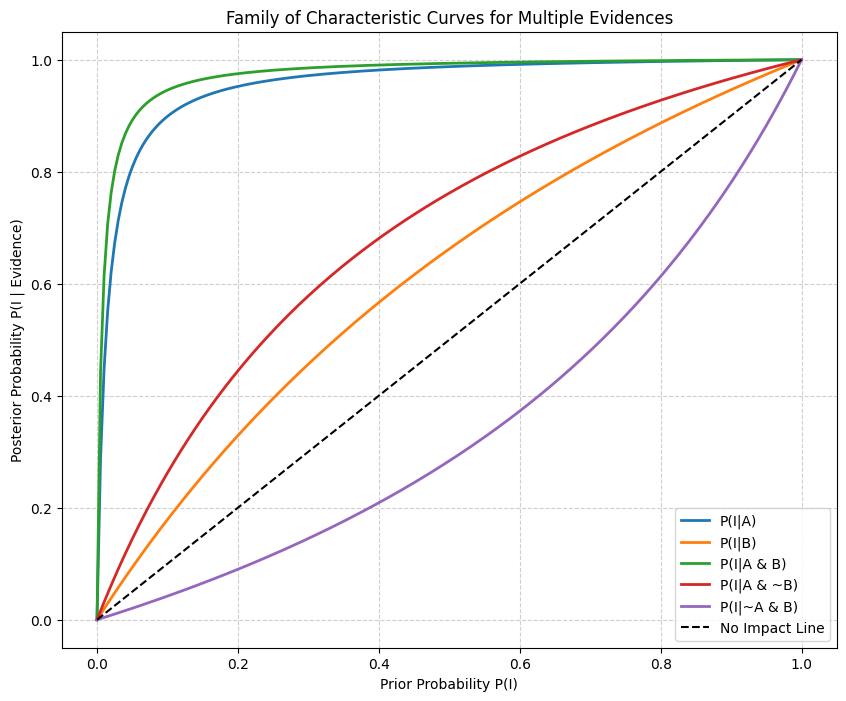

In [115]:
MultEvi = MultipleEvidence(2, test_mode=True)

MultEvi.plot_family_of_characteristics([
    ["A"],
    ["B"],
    ["A", "B"],
    ["A", "~B"],
    ["~A", "B"]
])


# 0.3 Conclusions

If only dog barks, it doesn't give us much more probability of burglary taking place, because dog often gives false alarms, barks from another reasons. The best result give us when dog barks and there is an alarm.

Loading hardcoded data

=== Data Collection Complete ===
Initial Event: {'name': 'I', 'prob': 0.002}
Conditional Evidences: {'A': {'prob_if_I_true': 0.8, 'prob_if_I_false': 0.01}, 'B': {'prob_if_I_true': 0.98, 'prob_if_I_false': 0.5}, '~A': {'prob_if_I_true': 0.19999999999999996, 'prob_if_I_false': 0.99}, '~B': {'prob_if_I_true': 0.020000000000000018, 'prob_if_I_false': 0.5}}


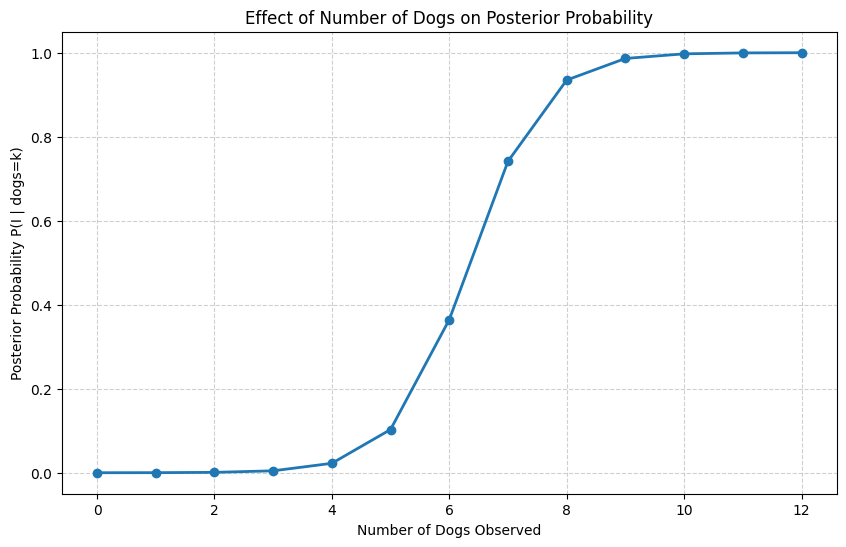

In [116]:
MultEvi = MultipleEvidence(2, test_mode=True)

# Now explore how the number of dogs affects belief
MultEvi.plot_effect_of_dogs(lambda_I=5, lambda_not_I=1, max_dogs=12)


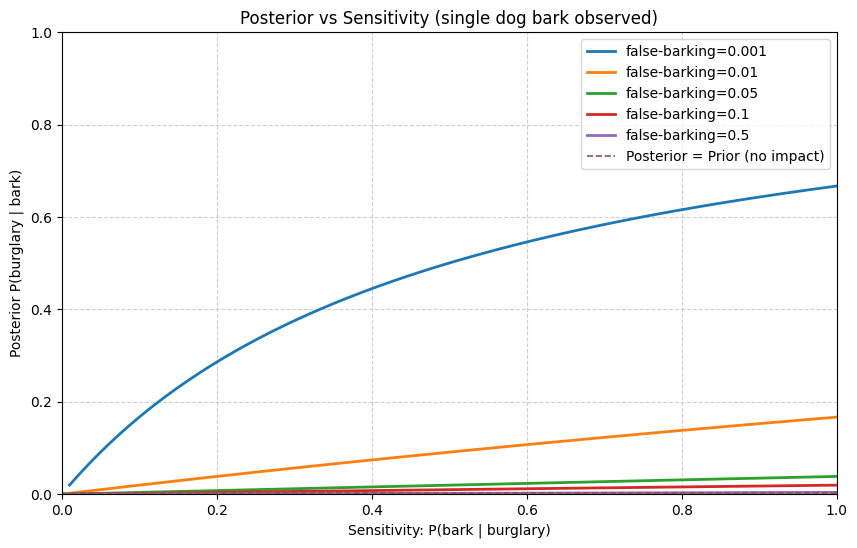

In [118]:
MultEvi.plot_posterior_vs_sensitivity_false_barking()

In situation when the alarm is not silent - it blares horn and flashes light when it goes off, computations can't be performed in the same manner, because they may affect on dog's barking and then these evidences won't be indepen